In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [2]:
outliers_df = pd.read_csv('outliers-data.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   prev_sold_date  7757 non-null   object 
 6   price           7757 non-null   float64
dtypes: float64(6), object(1)
memory usage: 424.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   price           7757 non-null   float64
 6   prev_sold_year  7757 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 424.3 KB


In [5]:
features = ["bed","bath","acre_lot","zip_code","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

In [6]:
X = outliers_df[features]
y = outliers_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [7]:
results_dict = {"model":[],"mae score":[],"mse score":[],"r2 score":[]}

In [8]:
def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [9]:
lasso = linear_model.Lasso(random_state=42)
lasso_sfs = SequentialFeatureSelector(estimator=lasso, n_features_to_select=num_features_to_select)
lasso_sfm = SelectFromModel(estimator=lasso, threshold=1000)
lasso_rfe = RFE(estimator=lasso, n_features_to_select=num_features_to_select)

In [10]:
lasso_pipeline = Pipeline([
  ('regression', lasso)
])

lasso_model = lasso_pipeline.fit(X_train,y_train)

In [11]:
lasso_predict_train = lasso_model.predict(X_train)
print_more_stuff("Lasso Regression Train",y_train,lasso_predict_train)

Lasso Regression Train MSE = 117,696,498,952.487061
Lasso Regression Train MAE = 222,667.122620
Lasso Regression Train R2 = 0.333536


In [12]:
lasso_predict = lasso_model.predict(X_test)
print_more_stuff("Lasso Regression Test",y_test,lasso_predict)

Lasso Regression Test MSE = 123,732,489,420.844391
Lasso Regression Test MAE = 226,348.922371
Lasso Regression Test R2 = 0.379322


In [13]:
lasso_sfm_pipeline = Pipeline([
  ('feature_selection', lasso_sfm),
  ('regression', lasso)
])

lasso_sfm_fs = lasso_sfm_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
lasso_sfm_get_support = lasso_sfm_fs.get_support()

print('The selected features are:', list(X.columns[lasso_sfm_get_support]))

The selected features are: ['bed', 'bath', 'acre_lot', 'prev_sold_year']


In [14]:
lasso_sfm_model = lasso_sfm_pipeline.fit(X_train,y_train)
lasso_sfm_predict = lasso_sfm_model.predict(X_test)
print_more_stuff("SelectFromModel",y_test,lasso_sfm_predict)

SelectFromModel MSE = 124,167,127,089.495514
SelectFromModel MAE = 226,661.254024
SelectFromModel R2 = 0.377142


In [15]:
lasso_sfs_pipeline = Pipeline([
  ('feature_selection', lasso_sfs),
  ('regression', lasso)
])

lasso_sfs_fs = lasso_sfs_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
lasso_sfs_get_support = lasso_sfs_fs.get_support()

print('The selected features are:', list(X.columns[lasso_sfs_get_support]))

The selected features are: ['bed', 'bath', 'zip_code', 'house_size', 'prev_sold_year']


In [16]:
lasso_sfs_model = lasso_sfs_pipeline.fit(X_train,y_train)
lasso_sfs_predict = lasso_sfs_model.predict(X_test)
print_more_stuff("SequentialFeatureSelector",y_test,lasso_sfs_predict)

SequentialFeatureSelector MSE = 123,865,782,459.714569
SequentialFeatureSelector MAE = 226,461.598118
SequentialFeatureSelector R2 = 0.378654


In [17]:
lasso_rfe_pipeline = Pipeline([
  ('feature_selection', lasso_rfe),
  ('regression', lasso)
])
lasso_rfe_fs = lasso_rfe_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
lasso_rfe_get_support = lasso_rfe_fs.get_support()

print('The selected features are:', list(X.columns[lasso_rfe_get_support]))

The selected features are: ['bed', 'bath', 'acre_lot', 'zip_code', 'prev_sold_year']


In [18]:
lasso_rfe_model = lasso_rfe_pipeline.fit(X_train,y_train)
lasso_rfe_predict = lasso_rfe_model.predict(X_test)
print_more_stuff("Recursive Feature Elimination",y_test,lasso_rfe_predict)

Recursive Feature Elimination MSE = 123,813,059,785.192276
Recursive Feature Elimination MAE = 226,371.869554
Recursive Feature Elimination R2 = 0.378918


https://scikit-learn.org/stable/modules/feature_selection.html#select-from-model

In [19]:
lasso_pipe = Pipeline([('lasso', linear_model.Lasso())])
param_dict = {'lasso__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

In [20]:
lasso_gscv = GridSearchCV(lasso_pipe, param_grid=param_dict)

In [21]:
lasso_gscv_model = lasso_gscv.fit(X, y)
lasso_gscv_predict = lasso_gscv_model.predict(X_test)
print_more_stuff("Grid Search CV",y_test,lasso_gscv_predict)

Grid Search CV MSE = 123,246,689,985.162933
Grid Search CV MAE = 227,354.215640
Grid Search CV R2 = 0.381759


In [22]:
lasso_predict_df = pd.DataFrame(lasso_predict).reset_index()
lasso_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfm_predict_df = pd.DataFrame(lasso_sfm_predict).reset_index()
lasso_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfs_predict_df = pd.DataFrame(lasso_sfs_predict).reset_index()
lasso_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_rfe_predict_df = pd.DataFrame(lasso_rfe_predict).reset_index()
lasso_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

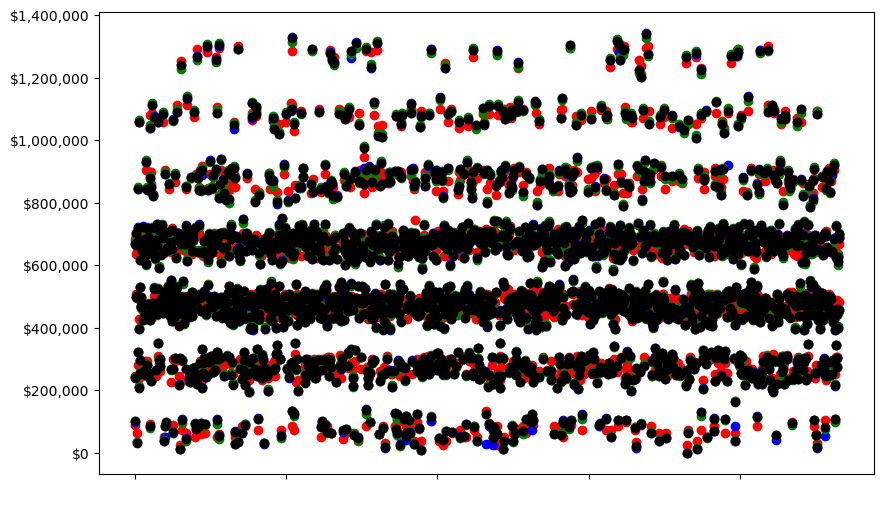

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="red")
plt.scatter(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="blue")
plt.scatter(lasso_rfe_predict_df.index,lasso_rfe_predict_df["prediction"], color="green")
plt.scatter(lasso_predict_df.index,lasso_predict_df["prediction"], color="black")
plt.show()

In [24]:
lasso_predict_df.sort_values(by='prediction', inplace=True)
lasso_predict_df.reset_index(inplace=True)

lasso_sfm_predict_df.sort_values(by='prediction', inplace=True)
lasso_sfm_predict_df.reset_index(inplace=True)

lasso_sfs_predict_df.sort_values(by='prediction', inplace=True)
lasso_sfs_predict_df.reset_index(inplace=True)

lasso_rfe_predict_df.sort_values(by='prediction', inplace=True)
lasso_rfe_predict_df.reset_index(inplace=True)

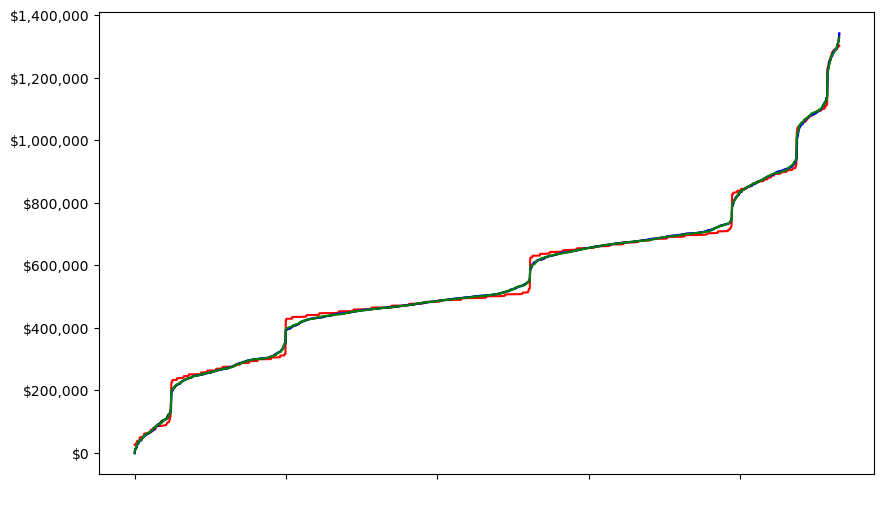

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(lasso_predict_df.index,lasso_predict_df["prediction"], color="black")
plt.plot(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="red")
plt.plot(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="blue")
plt.plot(lasso_rfe_predict_df.index,lasso_rfe_predict_df["prediction"], color="green")
plt.show()

In [26]:
lasso_predic_train_df = pd.DataFrame(lasso_predict_train).reset_index()
lasso_predic_train_df.rename(columns={0: "prediction"},inplace=True)

lasso_predic_train_df.sort_values(by='prediction', inplace=True)
lasso_predic_train_df.reset_index(inplace=True)

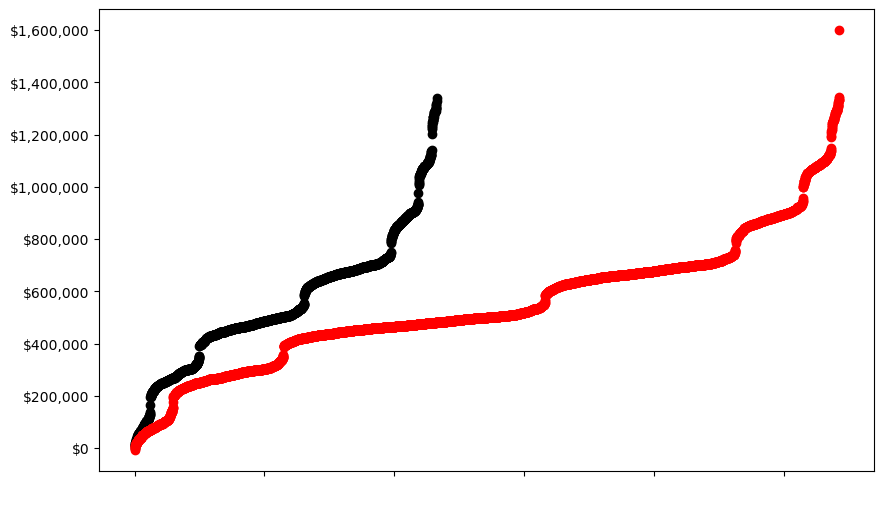

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(lasso_predict_df.index,lasso_predict_df["prediction"], color="black")
plt.scatter(lasso_predic_train_df.index,lasso_predic_train_df["prediction"], color="red")
plt.show()

In [28]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,mae score,mse score,r2 score
model,,,
Lasso Regression Train,"222,667.122620","117,696,498,952.487061",0.333536
Lasso Regression Test,"226,348.922371","123,732,489,420.844391",0.379322
SelectFromModel,"226,661.254024","124,167,127,089.495514",0.377142
SequentialFeatureSelector,"226,461.598118","123,865,782,459.714569",0.378654
Recursive Feature Elimination,"226,371.869554","123,813,059,785.192276",0.378918
Grid Search CV,"227,354.215640","123,246,689,985.162933",0.381759
